<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/MARCA-Color.jpg" title="Title text" width="50%" height="50%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales II-2018 </h1>

<H3 align='center'> Tarea 2 - Redes Convolucionales y sus aplicaciones </H3>
<hr style="height:2px;border:none"/>

### Pregunta 2. Transfer Learning.

Integrantes:

- Christian Da Rocha, ROL: 2018.90.251-9
- Rodrigo Hermosilla, ROL: 95.74.144-4


##### Carga inicial de librerias
> En la siguiente sección y de manera previa se cargan todas las librerías necesarias para el ejercicio. Para efectos de mantener cierto orden con el código de las preguntas del ejercicio, se determino que todas las cargas se realizaran previamente, no obstante, se entiende que esto podría generar alguna ineficiencia en el consumo de recursos, pero que suponemos es marginal.

In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout, Bidirectional, CuDNNGRU, GRU
from sklearn.metrics import f1_score
from heapq import nlargest
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from sklearn.metrics import classification as classification_metrics
import sklearn.datasets
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
import random,sys
from keras.callbacks import LambdaCallback
import itertools

Using TensorFlow backend.


##### Pregunta A.

<div class="alert alert-block alert-success">
    <b>Nota: </b>Para efectos de mejorar la modularización, el ejercicio construye una serie de funciones, permitiendo además su reutilización en distintos instantes.
</div>

In [2]:
df_ner = pd.read_csv("ner.csv", encoding ="cp1252", error_bad_lines=False)
df_ner.dropna(inplace=True)
dataset = df_ner.loc[:,["lemma","word","pos","tag","prev-iob"]]
dataset.head()

b'Skipping line 281837: expected 25 fields, saw 34\n'


,lemma,word,pos,tag,prev-iob
0,thousand,Thousands,NNS,O,__START1__
1,of,of,IN,O,O
2,demonstr,demonstrators,NNS,O,O
3,have,have,VBP,O,O
4,march,marched,VBN,O,O


In [3]:
print(dataset.loc[0],"\n\n",dataset.loc[27],"\n\n",dataset.loc[1050783])

lemma         thousand
word         Thousands
pos                NNS
tag                  O
prev-iob    __START1__
Name: 0, dtype: object 

 lemma         kill
word        killed
pos            VBN
tag              O
prev-iob         O
Name: 27, dtype: object 

 lemma         explod
word        exploded
pos              VBD
tag                O
prev-iob           O
Name: 1050783, dtype: object


In [4]:
def dataCreater():
    dataX,dataY = [],[]
    lemmas,labels = set(), set()
    sentence= []
    labels_sentence = []
    for fila in dataset.values:
        if fila[-1]=="__START1__": 
            dataX.append(np.asarray(sentence))
            dataY.append(np.asarray(labels_sentence))
            sentence= []
            labels_sentence = []
        lemmas.add(fila[0])
        labels.add(fila[3])
        sentence.append(fila[0])
        labels_sentence.append(fila[3])
    datax = np.asarray(dataX[1:])
    datay = np.asarray(dataY[1:])
    return datax, datay

> Porque las palabras en la columna Lemma no están en las letras mayúsculas, ninguna palabra también esta en el plural y todos los verbos están en la forma estándar.Mirar ejemplo abajo.

In [5]:
dataX, dataY = dataCreater()
print("Dimensiones de dataX =",len(dataX),"\nDimensiones de dataY =",len(dataY))
print(dataX[0], dataY[0])

Dimensiones de dataX = 48081 
Dimensiones de dataY = 48081
['thousand' 'of' 'demonstr' 'have' 'march' 'through' 'london' 'to'
 'protest' 'the' 'war' 'in' 'iraq' 'and' 'demand' 'the' 'withdraw' 'of'
 'british' 'troop' 'from' 'that' 'countri' '.'] ['O' 'O' 'O' 'O' 'O' 'O' 'B-geo' 'O' 'O' 'O' 'O' 'O' 'B-geo' 'O' 'O' 'O'
 'O' 'O' 'B-gpe' 'O' 'O' 'O' 'O' 'O']


##### Pregunta B.

In [6]:
def arrayNumber():
    Number = []
    for i in range(len(dataX)):
        Number.append(len(dataX[i]))
    return Number

In [7]:
def wordSplit():
    word = []
    for i in range(len(dataX)):
        for k in range(len(dataX[i])):
            word.append(dataX[i][k])
    word = list(set(word))
    return word

In [8]:
def wordCounter():
    num = 0
    for i in range(len(dataX)):
        for k in range(len(dataX[i])):
            num += 1
    return num

In [9]:
def numberWord():
    words = newDataX
    counts = {}
    for word in words:
        if word not in counts:
            counts[word] = 0
        counts[word] += 1
    counts.pop(',', None)
    counts.pop('.', None)
    return counts

In [10]:
def convertData():
    newDatax = []
    for i in range (len(dataX)):
        for k in range(len(dataX[i])):
            newDatax.append(dataX[i][k])     
    newDatay = []
    for i in range (len(dataY)):
        for k in range(len(dataY[i])):
            newDatay.append(dataY[i][k])
    return newDatax, newDatay

In [11]:
def graphMakerDest():
    numbers = [0]*len(arrayNum)
    for i in range(len(arrayNum)):
        numbers[arrayNum[i]] += 1
    plt.plot(numbers,'r-', linewidth = 1.5)
    plt.axis([min(arrayNum)-1,max(arrayNum)+1, 0, max(numbers)+50])
    plt.ylabel('Distribución')
    plt.xlabel('Palabras')
    plt.title('Cuantidad de palabras en uno Array')
    plt.show()
    print('Numero de palabras :',wordCo,'\nNumero de palabras que no sin repticion :',len(wordSp))

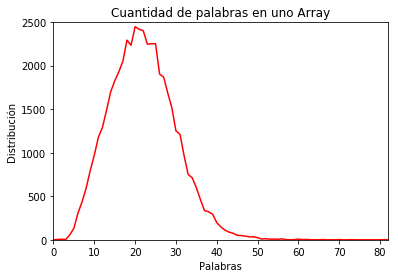

Numero de palabras : 1050786 
Numero de palabras que no sin repticion : 20243


In [12]:
wordSp = wordSplit()
wordCo = wordCounter()
newDataX,newDataY = convertData()
arrayNum = arrayNumber()
graphMakerDest()

In [13]:
def graphWordDes():
    plt.plot(list(dictWord.values()),'bo', markersize=2)
    plt.axis([0, len(wordSp), 0, max(dictWord.values())*1.07])
    plt.ylabel('Cuantidad')
    plt.xlabel('Palabras')
    plt.title('Palabra que más aparecen')
    plt.show()
    print('Cinco palabras que más aparecen',nlargest(5, dictWord, key=dictWord.get))

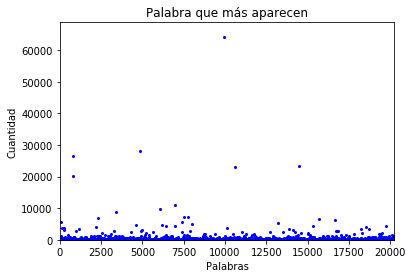

Cinco palabras que más aparecen ['the', 'in', 'of', 'to', 'a']


In [14]:
dictWord = numberWord()
graphWordDes()

In [15]:
def zipf():
    word = list(dictWord.values())
    total = wordCo
    frec = []
    for i in range(len(word)):
        temp = word[i]/total
        frec.append(temp*100)
    plt.plot((frec)*100,'go', markersize=2)
    plt.axis([0, len(word), 0, max(frec)*1.04])
    plt.ylabel('%')
    plt.xlabel('Palabras')
    plt.title('Frecuencia de las palabras')
    plt.show()
    print('Cinco mayor % :',nlargest(5, frec))

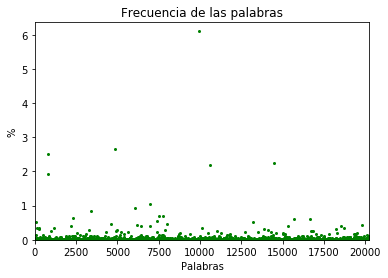

Cinco mayor % : [6.115422169690118, 2.6634348002352524, 2.5144035036629724, 2.2321386086224977, 2.1790355029473174]


In [16]:
zipf()

> No se observa una ley de Zipf porque la ley dice que la segunda palabra tiene que tener una frecuencia de 1/2 de la primera, la terceira 1/3 asin hasta la ultima, y como pudemos mirar las frequencias no tiene ese estandar.

In [17]:
def TagCounter():
    words = newDataY
    counts = {}
    for word in words:
        if word not in counts:
            counts[word] = 0
        counts[word] += 1
    return counts

In [18]:
def tagGraph():
    temp = tagSp
    plt.plot(list(temp.values()),'co', markersize=8)
    plt.axis([0, len(temp), 0, max(temp.values())*1.07])
    plt.ylabel('Cuantidad')
    plt.xlabel('Tags')
    plt.show()
    values = list(temp.values())
    keys = list(temp.keys())
    for i in range(len(keys)):
        print(keys[i], '=', values[i])

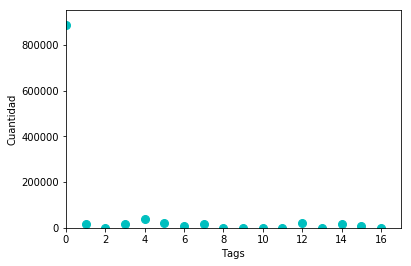

O = 889966
B-per = 17011
B-art = 434
I-per = 17382
B-geo = 37525
B-org = 20184
I-tim = 6298
B-gpe = 16391
I-eve = 297
I-gpe = 229
I-nat = 76
B-nat = 226
B-tim = 20193
I-art = 280
I-org = 16537
I-geo = 7409
B-eve = 348


In [19]:
tagSp = TagCounter()
tagGraph()

> La distrubuicion de palabra sin Tag (O) es lka mayor porque esas palabras san las pababras conectivas como: the, of, in.
Entonces eso es un resultado esperado.

<div class="alert alert-block alert-success">
    <b>Nota: </b>
    
geo = Entidad Geográfica

org = Organización

per = persona

gpe = entidad geopolítica

tim = indicador de tiempo

arte = artefacto

eve = Evento

nat = Fenómeno Natural

O = Nada
</div>

##### Pregunta C.

In [20]:
lemma2idx = {w: i for i, w in enumerate(wordSp)}
lab2idx = {t: i for i, t in enumerate(tagSp)}
numberDataX = [[lemma2idx[lemma] for lemma in sentence ] for sentence in dataX]
numberDataY = [[lab2idx[ner] for ner in ner_tags ] for ner_tags in dataY]
n_lemmas = len(wordSp)
n_labels = len(tagSp)
print(n_labels,n_lemmas)

17 20243


> Los valores estan corectos porque es la misma cuantidad de palabra y de tags en lo dataset original.

##### Pregunta D

In [21]:
max_input_lenght = max(arrayNum)
Xpost = sequence.pad_sequences(numberDataX, maxlen=max_input_lenght, padding='post',value=0)
Ypost = sequence.pad_sequences(numberDataY ,maxlen=max_input_lenght, padding='post',value=0)
Xpre = sequence.pad_sequences(numberDataX, maxlen=max_input_lenght, padding='pre',value=0)
Ypre = sequence.pad_sequences(numberDataY ,maxlen=max_input_lenght, padding='pre',value=0)

In [22]:
print('Los datos de X post\n',Xpost[0],'\n\n\nLos datos de Y post\n',Ypost[0],'\n\n\nLos datos de X pre\n',Xpre[0],'\n\n\nLos datos de Y pre\n',Ypre[0])

Los datos de X post
 [16603   792  3305  7365 17889  6974 13740 14496 12962  9920  3423  4161
 11806   799 13746  9920 12033   792    39 16484  4387 15702 16856 19443
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0] 


Los datos de Y post
 [0 0 0 0 0 0 4 0 0 0 0 0 4 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0] 


Los datos de X pre
 [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     

> Al pricinpio dela sentencia porque asin se la red no tendrá ningum problema con su aprendizaje

##### Pregunta E

In [23]:
y = np.asarray([to_categorical(i, num_classes=n_labels) for i in Ypost])
X_train, X_test, y_train, y_test = train_test_split(Xpost, Ypost, test_size=0.3,random_state=22)
y_train= keras.utils.to_categorical(y_train,num_classes=17)
y_test = keras.utils.to_categorical(y_test,num_classes=17)

In [24]:
print(len(X_train),len(X_test),len(y_train),len(y_test))

33656 14425 33656 14425


> Los vectores de entrada (X_train y y_train) tienen una dimension de 33656 que es 70% del datos de input (Xpost y Ypost) y los datos X_test y y_test tienen lo tamaño que queda del datos

##### Pregunta F

In [25]:
def model(x):
    embedding_vector = x
    model = Sequential()
    model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght))
    model.add(LSTM(units=100,return_sequences=True))
    model.add(Dense(n_labels, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)
    a = model.predict_classes(X_test,verbose=0)
    return a

In [26]:
modelF = model(32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 81, 32)            647776    
_________________________________________________________________
lstm_1 (LSTM)                (None, 81, 100)           53200     
_________________________________________________________________
dense_1 (Dense)              (None, 81, 17)            1717      
Total params: 702,693
Trainable params: 702,693
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 143s 4ms/step - loss: 0.4070 - val_loss: 0.1860
Epoch 2/3
33656/33656 [==============================] - 48s 1ms/step - loss: 0.1331 - val_loss: 0.1102
Epoch 3/3
33656/33656 [==============================] - 48s 1ms/step - loss: 0.0992 - val_loss: 0.0916


In [27]:
def convertY():
    new_y_test = []
    for i in range(len(y_test)):
        for k in range(len(y_test[i])):
            for j in range(len(y_test[i][k])):
                if y_test[i][k][j] > 0:
                    new_y_test.append(j)
    return new_y_test

In [28]:
new_y_test = convertY()

In [29]:
def predict(x):
    model = [item for sublist in x for item in sublist]
    print(classification_metrics.type_of_target(new_y_test))
    print(classification_metrics.type_of_target(model))
    print(len(model),len(new_y_test))
    print("F1 score on test: ", f1_score(new_y_test, model,average='macro'))

In [30]:
predict(modelF)

multiclass
multiclass
1168425 1168425
F1 score on test:  0.23171510014637176


C:\Users\Christian\Anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


> Cuando los datos entran en la red pasan por tres 'Gates', Keep Gate, Read Gate y Write Gate.
Write Gate es responsable de escribir los datos en la memoria.
Read Gate lee los datos de la memoria y envía los datos de nuevo a la red recurrente
Keep Gate es reponible por mantener o borrar datos de la memoria

<img src="LSTM.png" title="Title text" width="80%" height="50%" />

##### Pregunta G

In [ ]:
modelG_16 = model(16)
modelG_64 = model(64)
modelG_128 = model(128)
modelG_256 = model(256)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 81, 16)            323888    
_________________________________________________________________
lstm_2 (LSTM)                (None, 81, 100)           46800     
_________________________________________________________________
dense_2 (Dense)              (None, 81, 17)            1717      
Total params: 372,405
Trainable params: 372,405
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/3
20480/33656 [=================>............] - ETA: 17s - loss: 0.5377

In [ ]:
predict(modelG_16)
predict(modelG_64)
predict(modelG_128)
predict(modelG_256)

> Al aumentar el valor de embedding el error aumentó pero al usar un embedding menor el error cayó considerablemente. No fue algo esperado porque en la tarea 2 ejercicio 3 al almentar el embedding el resultado mejoraba, pero creo que como la cantidad de datos disponibles para entrenar en este ejercicio y el MSE es mucho menor la probable causa del hecho de menores embedding ser mejores es el Overfitting

##### Pregunta H

In [ ]:
def modelDrop(x):
    embedding_vector = x
    model = Sequential()
    model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght))  
    model.add(LSTM(units=100,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(Dense(n_labels, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)
    a = model.predict_classes(X_test,verbose=0)
    return a

In [ ]:
modelDrop = modelDrop(16)

In [ ]:
predict(modelDrop)

> El Dropout mejora mucho el funcionamiento de la red, porque como dicho en el ejercicio anterio probablemente esta teniendo Overfitting

##### Pregunta I

In [ ]:
def modelI(x,y):
    y = str(y)
    merge = {'1':'sum','2':'mul','3':'ave','4':'concat'}
    label = y
    embedding_vector = x
    model = Sequential()
    model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght))
    layer_lstm = LSTM(units=100,return_sequences=True)
    model.add(Bidirectional(layer_lstm,merge_mode=merge[y]))
    model.add(Dense(n_labels, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)
    a = model.predict_classes(X_test,verbose=0)
    return a

In [ ]:
modelI_1 = modelI(16,1)
modelI_2 = modelI(16,2)
modelI_3 = modelI(16,3)
modelI_4 = modelI(16,4)

In [ ]:
predict(modelI_1)
predict(modelI_2)
predict(modelI_3)
predict(modelI_4)

> El merge_mode de media presentó resultados mucho mejores que los otros probados y también mejora el desempeña de la red considerablemente

##### Pregunta J

In [ ]:
def modelJ(x):
    embedding_vector = x
    lemma2idx["yourspecialcharacter"] = 0 
    embedding_vector = 32
    model = Sequential()
    model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght,mask_zero=True))
    model.add(Dense(n_labels, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)
    a = model.predict_classes(X_test,verbose=0)
    return a

In [ ]:
modelJ = modelJ(16)

In [ ]:
predict(modelJ)

> El entrenamiento ocurrió con un error mayor al comienzo, y el tiempo de entrenamiento tuvo una variación considerable, pero el error aumentó considerablemente

##### Pregunta K

In [ ]:
def modelK(x,y,w):
    embedding_vector = x 
    y = str(y)
    merge = {'1':'sum','2':'mul','3':'ave','4':'concat'}
    model = Sequential()
    model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght))
    layer_lstm = LSTM(units=100,return_sequences=True)
    model.add(Bidirectional(layer_lstm,merge_mode=merge[y]))
    model.add(Dropout(w))
    model.add(Dense(n_labels, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)
    a = model.predict_classes(X_test,verbose=0)
    return a

In [ ]:
modelK_1 = modelK(16,3,0.2)

In [ ]:
predict(modelK_1)

##### Pregunta L

In [ ]:
def modelJ(x,y,w):
    embedding_vector = x 
    y = str(y)
    merge = {'1':'sum','2':'mul','3':'ave','4':'concat'}
    model = Sequential()
    model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght))
    layer_lstm = LSTM(units=100,return_sequences=True)
    model.add(Bidirectional(layer_lstm,merge_mode=merge[y]))
    model.add(Dropout(w))
    model.add(Dense(n_labels, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)
    return model

In [ ]:
p = modelJ(16,3,0.2)

In [ ]:
def modelJfit(x,y):
    model = x
    i = y
    p = model.predict(np.array([X_test[i]]))
    p = np.argmax(p, axis=-1)
    print("{:15}: {}".format("Lemma", "Pred"))
    for w,pred in zip(X_test[i],p[0]):
        if w != 0:
            print("{:15}: {}".format(wordSp[w],list(tagSp.keys())[pred]))

In [ ]:
modelJfit(p, random.randint(0, len(X_test)))

> En el caso de que la red no esta generando las Pred con mucha precisión pero esto puede ser explicado por el hecho de Tag 'O' tener un porcentaje mucho mayor de lo que las otras etiquetas y tal vez al encontrar otro ejemplo la red demuestre otras Tags

##### Pregunta M

In [ ]:
dataset = df_ner.loc[:,["word","lemma"]]
text = ' '.join(dataset["word"]).lower() 
null_character = "*"
chars = [null_character]+sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}
maxlen = 40 
step = 5 
sentences = []
next_chars = []
size = int(len(text)*0.25)
for i in range(0, size - maxlen, step):
    sentences.append(null_character+text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

>Se debe usa 'word' porque los verbos tienen tiempos verbales diferentes del presente y los tiempos verbales tiene grand peso en la seguinte palabra

##### Pregunta N

In [ ]:
dataX = [[char_indices[char] for char in sentence ] for sentence in sentences]
dataY = [char_indices[char] for char in next_chars]
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(dataX, dataY, test_size=0.3,random_state=22)
X_test_2 = sequence.pad_sequences(dataX, maxlen=41, padding='pre',value=0)
X_train_2 = sequence.pad_sequences(dataX, maxlen=41, padding='pre',value=0)
y_test_2 = keras.utils.to_categorical(dataY,num_classes=72)
y_train_2 = keras.utils.to_categorical(dataY,num_classes=72)

In [ ]:
def modelCuD():
    embedding_vector = 16
    model = Sequential()
    model.add(Embedding(input_dim=len(chars), output_dim=embedding_vector, input_length=maxlen+1))
    model.add(CuDNNGRU(units=512,return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(len(chars), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
def modelGru():
    embedding_vector = 16
    model = Sequential()
    model.add(Embedding(input_dim=len(chars), output_dim=embedding_vector, input_length=maxlen+1))
    model.add(GRU(units=512,return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(len(chars), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model 

##### Pregunta O (GRU)

In [ ]:
def predict_next_char(model, sentence):   
    x_pred = [char_indices[null_character]]+[char_indices[char] for char in sentence]
    x_pred = sequence.pad_sequences([x_pred], maxlen=maxlen+1,padding='pre',value=char_indices[null_character])
    preds = model.predict(x_pred, verbose=0)[0]
    next_index = np.random.choice(len(chars), p=preds)
    return indices_char[next_index]

In [ ]:
def on_epoch_end(epoch, logs):
    print('\n----- Generating text after Epoch: %d' % epoch)
    start_index = random.randint(0, size - maxlen - 1)
    sentence = text[start_index: start_index + maxlen]
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(sentence)
    for i in range(400):
        next_char = predict_next_char(modGru, sentence)
        sentence = sentence[1:] + next_char
        sys.stdout.write(next_char)
        sys.stdout.flush()
    return

In [ ]:
modGru = modelGru()

In [ ]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
modGru.fit(X_train_2, y_train_2,batch_size=256,epochs=25, callbacks=[print_callback])

##### Pregunta O (CuDNNGRU)

In [ ]:
def on_epoch_end(epoch, logs):
    print('\n----- Generating text after Epoch: %d' % epoch)
    start_index = random.randint(0, size - maxlen - 1)
    sentence = text[start_index: start_index + maxlen]
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(sentence)
    for i in range(400):
        next_char = predict_next_char(modCuD, sentence)
        sentence = sentence[1:] + next_char
        sys.stdout.write(next_char)
        sys.stdout.flush()
    return

In [ ]:
modCuD = modelCuD()

In [ ]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
modCuD.fit(X_train_2, y_train_2,batch_size=256,epochs=25, callbacks=[print_callback])

> La técnica es cambiando los valores de la función randint a los valores más cercanos de los esperados, los valores se cambian con el entrenamiento de red

##### Pregunta P (GRU)

In [ ]:
sentence = "it is "
print('----- Generating with seed: "' + sentence + '"')
sys.stdout.write(sentence)
for i in range(400):
    next_char = predict_next_char(modGru, sentence)
    sentence = sentence[1:] + next_char 
    sys.stdout.write(next_char)
    sys.stdout.flush()

##### Pregunta  P (CuDNNGRU)

In [ ]:
sentence = "it is "
print('----- Generating with seed: "' + sentence + '"')
sys.stdout.write(sentence)
for i in range(400):
    next_char = predict_next_char(modCuD, sentence)
    sentence = sentence[1:] + next_char 
    sys.stdout.write(next_char)
    sys.stdout.flush()

> Las frases generadas harían mucho menos sentido porque el efecto de la red sería mucho más sensible, así que el hecho de haber generado una frase con un sentido intetecto dice que la red fue entrenada de manera correcta